# Market Prediction

Elias Eskelinen, Vili Niemelä, Matti Aalto and Jarkko Komulainen

---

In this project, a model to predict the house-prices of the Philadelphia metropolitan areas in U.S. is implemented.

## Data onboarding

Fetch the data from the kaggle API (saved as a local file)

In [1]:
import os
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

c:\Users\Jarkko\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Fetch the latest version of the dataset from kaggle
# Requires authentication
data_dir = kagglehub.competition_download('hull-tactical-market-prediction')
data_path = os.path.join(data_dir, "train.csv")

100%|██████████| 4.01M/4.01M [00:00<00:00, 4.32MB/s]

Extracting files...


Load the data from the local file

In [5]:
data = pd.read_csv(data_path)
print(data.shape)
print(data.head())
print(data.info())

(9021, 98)
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entr

Format `date` column as `datetime` and set the `date` column as the dataset index

In [17]:
# date to index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

KeyError: 'date'

In [ ]:
# selecting only the Philadelphia-Camden-Wilmington metropolitan are
data = data[data["city_full"] == "Philadelphia-Camden-Wilmington"]
print(data.shape)
data.head()

(47428, 38)


,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,...,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full
date,,,,,,,,,,,,,,,,,,,,,
2012-03-31,148000.0,475000.0,92.964824,267.454955,1.0,1.0,1.0,6.0,187.0,0.930818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182388.393502,Philadelphia-Camden-Wilmington
2012-04-30,148000.0,475000.0,92.964824,267.454955,1.0,1.0,1.0,6.0,187.0,0.930818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182388.393502,Philadelphia-Camden-Wilmington
2012-05-31,148000.0,475000.0,92.964824,267.454955,1.0,1.0,1.0,6.0,187.0,0.930818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182388.393502,Philadelphia-Camden-Wilmington
2012-06-30,148000.0,359900.0,92.964824,156.478261,1.0,1.0,1.0,7.0,187.0,0.930818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182388.393502,Philadelphia-Camden-Wilmington
2012-07-31,148000.0,159000.0,92.964824,136.834320,1.0,1.0,5.0,10.0,187.0,0.930818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182388.393502,Philadelphia-Camden-Wilmington


---

## Data visualization and exploratory analysis

The time-series dataset consists of 884092 samples with 39 variables. The samples are monthly observations of housingThe predicted variable is `price`; the predictors are all numerical data, except for the `date` variable and the categorical variable `city_full`.

---

## Time-series decomposition analysis

For decomposition we use statsmodels Seasonal-Trend decomposition which decomposes time series into trend, seasonal, and residual. The method requires that the season length has to be defined.

Defining the corresponding hypreparameters by visually studying the price time series:

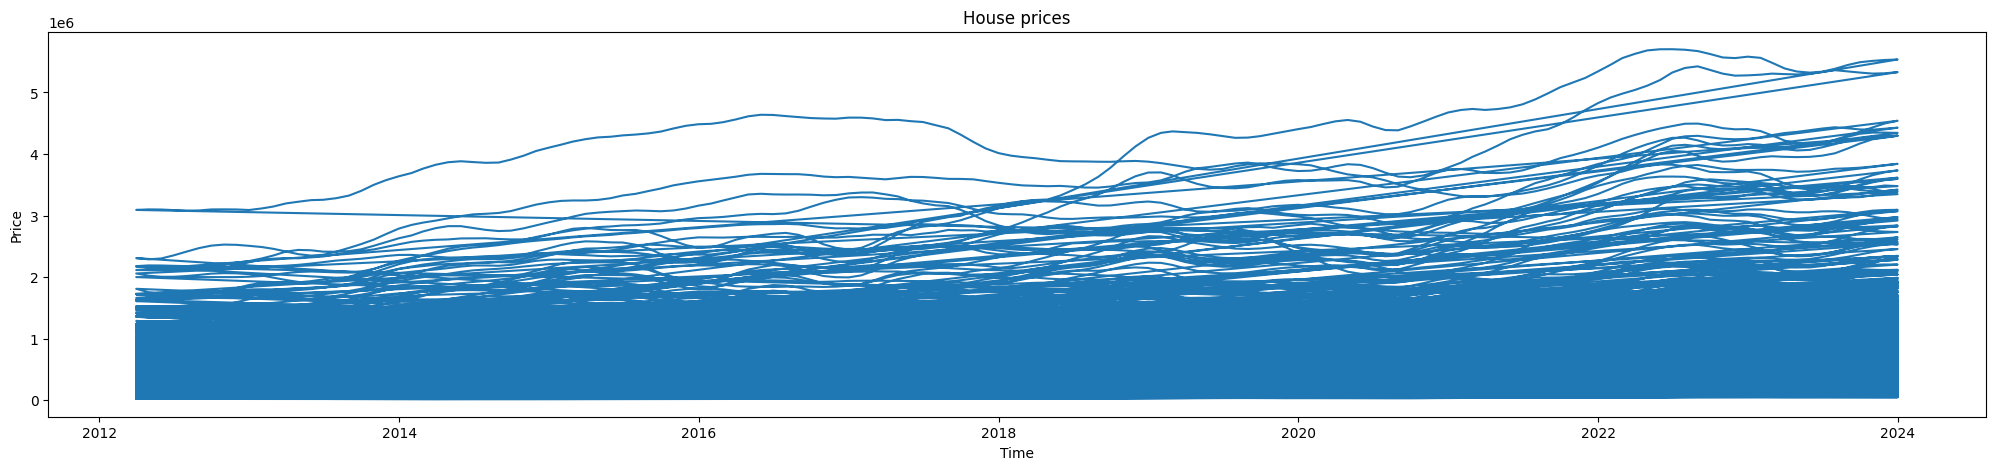

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(data["price"])
plt.title("House prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


In [ ]:
plt.figure(figsize=(25,5))
plt.plot(data.iloc["price"]) #20:10000,
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")

plt.figure(figsize=(25,5))
plt.plot(data["price"][400000:402000])
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")

plt.figure(figsize=(25,5))
plt.plot(data["price"][800000:802000])
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")

plt.figure(figsize=(25,5))
plt.plot(data["price"][800020:800200])
plt.plot(data.index[800028], data["price"][800028], "*r", label="start of the season: t=800028")
plt.plot(data.index[800170], data["price"][800170], "*g", label="end of the season t=800170")
plt.title("House prices zoomed")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

plt.show()

---

## Autocorrelation analysis

---

## Partitioning the time-series data